# Predicting Recommendation from Review Text : LSA vs Autoencoder vs NN

## Table of Content <a id="toc"></a>
* [Global Variables](#gv)
* [1. Data Preprocessing](#data_preprocessing)
    * [1.1 Importing Data and Separating Data of Our Interest](#1.1)
    * [1.2 Creating Preprocessing Function and Applying it on Our Data](#1.2)
    * [1.3 Creating TF-IDF Matrix](#1.3)
* [2. Apply SVD to TF-IDF Matrix](#apply_svd)
    * [2.1 Create Term and Document Representation](#2.1)
    * [2.2 Visulize Those Representation](#2.2)
* [3 Information Retreival Using LSA](#ir_lsa)
* [4. Create Model to Predict Recommendation](#4)
* [5. Train Autoencoder on TF-IDF Matrix](#5)
* [6. Information Retrieval Using Autoencoder](#6)
* [7. Predict Recommendation using Encoding of Autoencoder](#7)
* [8. Use simple NN to predict Recommendation](#8)

In [17]:
# Global Variables 
K = 2 # number of components
query = 'nice good price'

##  1. Data Preprocessing <a id="data_preprocessing"></a>

### 1.1 Importing Data and Separating Data of Our Interest <a id="1.1"></a>

In [18]:
import pandas as pd
import numpy as np

# Data filename
dataset_filename = "../input/Womens Clothing E-Commerce Reviews.csv"

# Loading dataset
data = pd.read_csv(dataset_filename, index_col=0)


# We are reducing the size of our dataset to decrease the running time of code
list_of_clothing_id = data['Clothing ID'].value_counts()[:10].index
y1 = [x == 0 for x in data['Recommended IND']]
y2 = [x in list_of_clothing_id for x in data['Clothing ID']]
y3 = [a or b for a,b in zip(y1,y2)]

datax = data.loc[y3, :]


# Delete missing observations for variables that we will be working with
for x in ["Recommended IND","Review Text"]:
    datax = datax[datax[x].notnull()]

# Keeping only those features that we will explore
datax = datax[["Recommended IND","Review Text"]]

# Resetting the index
datax.index = pd.Series(list(range(datax.shape[0])))
    
print('Shape : ',datax.shape)
datax.head()

Shape :  (8807, 2)


,Recommended IND,Review Text
0,0,I had such high hopes for this dress and reall...
1,0,"I love tracy reese dresses, but this one is no..."
2,0,Dress runs small esp where the zipper area run...
3,0,"First of all, this is not pullover styling. th..."
4,0,"Loved the material, but i didnt really look at..."


### 1.2 Creating Preprocessing Function and Applying it on Our Data <a id="1.2"></a>

In [19]:
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

wordnet_lemmatizer = WordNetLemmatizer()
tokenizer = RegexpTokenizer(r'[a-z]+')
stop_words = set(stopwords.words('english'))

def preprocess(document):
    document = document.lower() # Convert to lowercase
    words = tokenizer.tokenize(document) # Tokenize
    words = [w for w in words if not w in stop_words] # Removing stopwords
    # Lemmatizing
    for pos in [wordnet.NOUN, wordnet.VERB, wordnet.ADJ, wordnet.ADV]:
        words = [wordnet_lemmatizer.lemmatize(x, pos) for x in words]
    return " ".join(words)

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [20]:
datax['Processed Review'] = datax['Review Text'].apply(preprocess)

datax.head()

,Recommended IND,Review Text,Processed Review
0,0,I had such high hopes for this dress and reall...,high hope dress really want work initially ord...
1,0,"I love tracy reese dresses, but this one is no...",love tracy reese dress one petite foot tall us...
2,0,Dress runs small esp where the zipper area run...,dress run small esp zipper area run order sp t...
3,0,"First of all, this is not pullover styling. th...",first pullover style side zipper purchase know...
4,0,"Loved the material, but i didnt really look at...",love material didnt really look long dress pur...


### 1.3 Creating TF-IDF Matrix <a id="1.3"></a>

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
TF_IDF_matrix = vectorizer.fit_transform(datax['Processed Review'])
TF_IDF_matrix = TF_IDF_matrix.T

print('Vocabulary Size : ', len(vectorizer.get_feature_names()))
print('Shape of Matrix : ', TF_IDF_matrix.shape)

Vocabulary Size :  6686
Shape of Matrix :  (6686, 8807)


## 2. Apply SVD to TF-IDF Matrix <a id="apply_svd"></a>

### 2.1 Create Term and Document Representation  <a id="2.1"></a>

In [22]:
# import numpy as np

# # Applying SVD
# U, s, VT = np.linalg.svd(TF_IDF_matrix.toarray()) # .T is used to take transpose and .toarray() is used to convert sparse matrix to normal matrix

# TF_IDF_matrix_reduced = np.dot(U[:,:K], np.dot(np.diag(s[:K]), VT[:K, :]))

# # Getting document and term representation
# terms_rep = np.dot(U[:,:K], np.diag(s[:K])) # M X K matrix where M = Vocabulary Size and N = Number of documents
# docs_rep = np.dot(np.diag(s[:K]), VT[:K, :]).T # N x K matrix 

In [23]:
import numpy as np
from scipy.sparse.linalg import svds

# Applying SVD
U, s, VT = svds(TF_IDF_matrix) # .T is used to take transpose and .toarray() is used to convert sparse matrix to normal matrix

TF_IDF_matrix_reduced = np.dot(U[:,:K], np.dot(np.diag(s[:K]), VT[:K, :]))

# Getting document and term representation
terms_rep = np.dot(U[:,:K], np.diag(s[:K])) # M X K matrix where M = Vocabulary Size and N = Number of documents
docs_rep = np.dot(np.diag(s[:K]), VT[:K, :]).T # N x K matrix 

### 2.2 Visulize Those Representation <a id="2.2"></a>

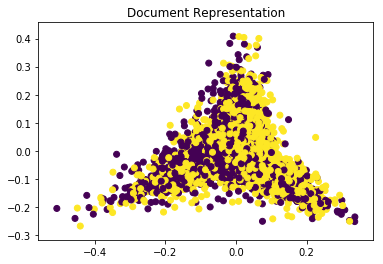

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(docs_rep[:,0], docs_rep[:,1], c=datax['Recommended IND'])
plt.title("Document Representation")
plt.show()

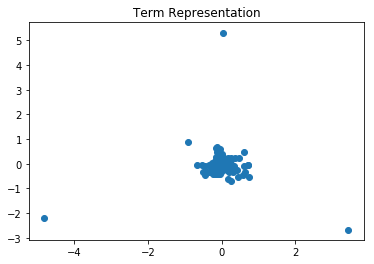

In [25]:
plt.scatter(terms_rep[:,0], terms_rep[:,1])
plt.title("Term Representation")
plt.show()

## 3 Information Retreival Using LSA <a id="ir_lsa"></a>

In [26]:
# This is a function to generate query_rep

def lsa_query_rep(query):
    query_rep = [vectorizer.vocabulary_[x] for x in preprocess(query).split()]
    query_rep = np.mean(terms_rep[query_rep],axis=0)
    return query_rep

In [27]:
from scipy.spatial.distance import cosine

query_rep = lsa_query_rep(query)

query_doc_cos_dist = [cosine(query_rep, doc_rep) for doc_rep in docs_rep]
query_doc_sort_index = np.argsort(np.array(query_doc_cos_dist))

print_count = 0
for rank, sort_index in enumerate(query_doc_sort_index):
    print ('Rank : ', rank, ' Consine : ', 1 - query_doc_cos_dist[sort_index],' Review : ', datax['Review Text'][sort_index])
    if print_count == 4 :
        break
    else:
        print_count += 1

Rank :  0  Consine :  0.9999999969568675  Review :  This looks sooooo much better on, than on the hanger/in the picture. i bought the grey, and it is the most comfortable tunic i've ever worn. it is light, airy, and so easy to wear. i wish it came in more prints/colors, cause i'd buy another one, in a skinny minute! if you don't try this on, you're missing out on a surprisingly awesome wardrobe piece. you can wear it year-round with jeans, pants, a vest, wrap, scarves, leggings, boots, sandals or anything else, and it looks chic and whimsical. go
Rank :  1  Consine :  0.9999999837151998  Review :  This dress is amazing! ordered one with a discount (the dark blue with flowers print) and it was becoming my go-to for work so had to bite the bullet and order two other colors full price. size m fit perfect 5'7" 150#
Rank :  2  Consine :  0.9999999320306875  Review :  Well, i wanted to love it and it was just too much. i think it is a bit wider and weirdly baggier than it should be. i also f

## 4. Create Model to Predict Recommendation <a id="4"></a>

In [28]:
from keras.layers import Input, Dense
from keras.models import Model
from sklearn.model_selection import train_test_split

def create_logistic_model(X,y):
    
    # Splitting data for training and validation
    x_train, x_test, y_train, y_test = train_test_split(pd.DataFrame(X),y,test_size=0.1, random_state=1)
    
    # Getting the input dimension
    input_dim = X.shape[1]
    
    # this is our input placeholder
    input_doc = Input(shape=(input_dim,))
    # This is dense layer
    dense_layer = Dense(1, activation='sigmoid')(input_doc)
    # Our final model
    model = Model(input_doc, dense_layer)
    
    # Compiling model
    model.compile(optimizer='sgd', loss='binary_crossentropy',metrics=['accuracy'])
    
    
    # Training model
    history = model.fit(x_train, y_train,
                epochs=5,
                batch_size=100,
                shuffle=True,
                validation_data=(x_test, y_test),
                verbose=0)
    # Printing Accuracy
    print('Accuracy on Training Data : ', history.history['acc'][-1])
    print('Accuracy on Validation Data : ', history.history['val_acc'][-1])
    
    # Returning model
    return model, history

In [29]:
model_using_lsa, history = create_logistic_model(docs_rep, datax['Recommended IND'])

Accuracy on Training Data :  0.506434515648769
Accuracy on Validation Data :  0.5073779739532513


In [30]:
datax['Recommended IND'].value_counts() / datax['Recommended IND'].shape[0]

1    0.534348
0    0.465652
Name: Recommended IND, dtype: float64

In [31]:
print(np.sum(model_using_lsa.predict(docs_rep) > .5))
print(docs_rep.shape[0])

7864
8807


## 5. IR using Autoencoder with TF-IDF matrix <a id="5"></a>

In [32]:
from sklearn.model_selection import train_test_split
from keras.layers import Input, Dense
from keras.models import Model

encoding_dim = 2 # Size of encoding
input_dim = TF_IDF_matrix.shape[0] # Size of docs

# Splitting Data for training and validation
df = pd.DataFrame(TF_IDF_matrix.T.toarray())
x_train, x_val, y_train, y_val = train_test_split(df, df[0], test_size=0.1, random_state=1)

# Encoder and Decoder
# this is our input placeholder
input_docs = Input(shape=(input_dim,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='tanh')(input_docs)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(input_dim, activation='relu')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_docs, decoded)

# this model maps an input to its encoded representation
encoder = Model(input_docs, encoded)

# create a placeholder for an encoded (2-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

autoencoder.compile(loss='mean_squared_error', optimizer='sgd')

history = autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=100,
                shuffle=True,
                verbose=0,
                validation_data=(x_val, x_val))

# encode and decode some data points
print('Original Data : ', x_val[:5])
encoded_datapoints = encoder.predict(x_val[:5])
print('Encodings : ', encoded_datapoints)
decoded_datapoints = decoder.predict(encoded_datapoints)
print('Reconstructed Data : ', decoded_datapoints)

Original Data :        0     1     2     3     4     ...   6681  6682  6683  6684  6685
2894   0.0   0.0   0.0   0.0   0.0  ...    0.0   0.0   0.0   0.0   0.0
2161   0.0   0.0   0.0   0.0   0.0  ...    0.0   0.0   0.0   0.0   0.0
6363   0.0   0.0   0.0   0.0   0.0  ...    0.0   0.0   0.0   0.0   0.0
2575   0.0   0.0   0.0   0.0   0.0  ...    0.0   0.0   0.0   0.0   0.0
2698   0.0   0.0   0.0   0.0   0.0  ...    0.0   0.0   0.0   0.0   0.0

[5 rows x 6686 columns]
Encodings :  [[ 0.00328046  0.0259432 ]
 [-0.00038167  0.00516556]
 [ 0.00734468 -0.00509106]
 [ 0.00838482  0.00335973]
 [-0.00261952 -0.03357777]]
Reconstructed Data :  [[8.4079802e-05 5.4465968e-04 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 6.9409015e-04]
 [0.0000000e+00 1.2615910e-04 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 1.4602696e-04]
 [2.0082628e-04 0.0000000e+00 1.5571286e-04 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [2.2786355e-04 0.0000000e+00 1.2964604e-04 ... 0.0000000e+00
  0.0000000e+00 0.00

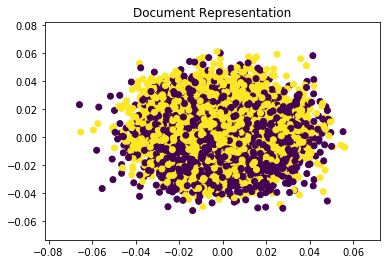

In [33]:
docs_rep_autoencoder = encoder.predict(TF_IDF_matrix.T)

import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(docs_rep_autoencoder[:,0], docs_rep_autoencoder[:,1], c=datax['Recommended IND'])
plt.title("Document Representation")
plt.show()

## 6 Information Retreival Using Autoencoder <a id="6"></a>

In [34]:
# This is a function to generate query_rep
def autoencoder_query_rep(query):
    query_rep = vectorizer.transform([query])
    query_rep = encoder.predict(query_rep)
    return query_rep

In [35]:
from scipy.spatial.distance import cosine

query_rep = autoencoder_query_rep(query)

query_doc_cos_dist = [cosine(query_rep, doc_rep) for doc_rep in docs_rep]
query_doc_sort_index = np.argsort(np.array(query_doc_cos_dist))

print_count = 0
for rank, sort_index in enumerate(query_doc_sort_index):
    print ('Rank : ', rank, ' Consine : ', 1 - query_doc_cos_dist[sort_index],' Review : ', datax['Review Text'][sort_index])
    if print_count == 4 :
        break
    else:
        print_count += 1

Rank :  0  Consine :  0.9999998876092323  Review :  Beautiful and delicate!!
Rank :  1  Consine :  0.9999975435554772  Review :  What a great find! this is so easy to dress up or down and a very comfortable fit and fabric. the skirt fabric is pretty form fitting so not something i can comfortably wear to work but it's a versatile piece otherwise. the buttons on the sleeve are a nice touch.
Rank :  2  Consine :  0.9999963676604915  Review :  The picture does not do it justice. this dress is beautiful on. it is fitted on the top and flares on the bottom. it is also a very soft denim. the person helping me at the store brought a sparkly belt that made it even more spectacular. truth is it looks great with or without the belt. it fits true to size (5'4", 135 lbs and 34c and my usual size 2 was great).
Rank :  3  Consine :  0.9999924419557935  Review :  This is a great dress that looks better in reality than it shows on the website. the style is very flattering, fitting snug at the waist wi

## 7. Predict Recommendation using Encoding of Autoencoder <a id="7"></a>

In [36]:
model_using_autoencoder, history = create_logistic_model(docs_rep_autoencoder, datax['Recommended IND'])

Accuracy on Training Data :  0.534569766946793
Accuracy on Validation Data :  0.5323495973117235


In [37]:
datax['Recommended IND'].value_counts() / datax['Recommended IND'].shape[0]

1    0.534348
0    0.465652
Name: Recommended IND, dtype: float64

In [38]:
print(np.sum(model_using_lsa.predict(docs_rep) > .5))
print(docs_rep.shape[0])

7864
8807


## 8. Use simple NN to predict Recommendation <a id="8"></a>

In [39]:
from sklearn.model_selection import train_test_split
from keras.layers import Input, Dense
from keras.models import Model

input_dim = TF_IDF_matrix.shape[0] # Size of docs

# Splitting Data for training and validation
df = pd.DataFrame(TF_IDF_matrix.T.toarray())
x_train, x_val, y_train, y_val = train_test_split(df, datax['Recommended IND'], test_size=0.1, random_state=1)

# this is our input placeholder
input_docs = Input(shape=(input_dim,))
layer1 = Dense(100, activation='relu')(input_docs)
layer2 = Dense(10, activation='relu')(layer1)
layer3 = Dense(2, activation='relu')(layer2)
layer4 = Dense(1, activation='sigmoid')(layer3)

# Get encoding
encoder = Model(input_docs, layer3)

# Final Model
model = Model(input_docs, layer4)

model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])

history = model.fit(x_train, y_train,
                epochs=125,
                batch_size=100,
                shuffle=True,
                verbose=0,
                validation_data=(x_val, y_val))

# Printing Accuracy
print('Accuracy on Training Data : ', history.history['acc'][-1])
print('Accuracy on Validation Data : ', history.history['val_acc'][-1])

Accuracy on Training Data :  0.9390613194399942
Accuracy on Validation Data :  0.8751418846960641


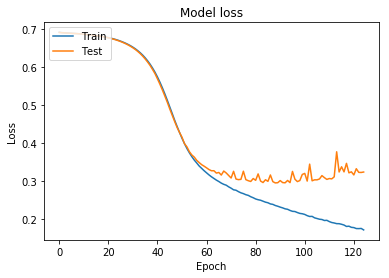

In [40]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Displaying all plot of encodings and saving these for report

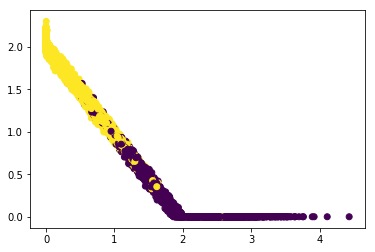

<Figure size 432x288 with 0 Axes>

In [41]:
docs_rep_nn = encoder.predict(TF_IDF_matrix.T)

import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(docs_rep_nn[:,0], docs_rep_nn[:,1], c=datax['Recommended IND'])
plt.show()

plt.savefig('doc_rep_plot_nn.png')

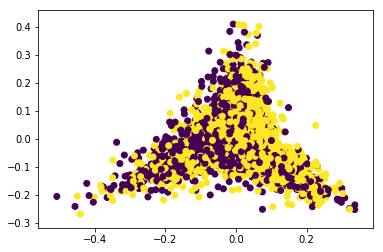

<Figure size 432x288 with 0 Axes>

In [42]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(docs_rep[:,0], docs_rep[:,1], c=datax['Recommended IND'])
plt.show()

plt.savefig('doc_rep_plot_lsa.png')

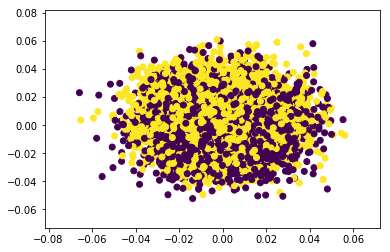

<Figure size 432x288 with 0 Axes>

In [43]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(docs_rep_autoencoder[:,0], docs_rep_autoencoder[:,1], c=datax['Recommended IND'])
plt.show()

plt.savefig('doc_rep_plot_ae.png')